In [ ]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import sys
sys.path.append('../..')
from model import FinData
from model import merged_split
from model import CatboostFinModel
from model import mul_PCA

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


Функция для торгов

In [78]:
def trade_test(X_test, y_test, fitted_model, initial_budget = 10000, short=False, commision = 0.0004):
    history = []
    money = initial_budget


    for i in range(X_test.shape[0] - 1):
        y_pred = fitted_model.predict(X_test.iloc[i])
        close_in_ten_min = y_test.iloc[i + 1].item()
        open_now = y_test.iloc[i].item()
        history.append(money)

        if money >= open_now and y_pred == 1:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money  // open_now)
            money += (close_in_ten_min - open_now) * (money  // open_now) - commission_now
            print(f"LONG! Earning {(close_in_ten_min - open_now) * (money  // open_now)} - commission {commission_now} -> budget: {money}")

        elif y_pred == 0 and short == True:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money // close_in_ten_min)
            money += (open_now - close_in_ten_min) * (money  // open_now) - commission_now

    print(f"\n\n\nMy budget before {initial_budget} and after trading {money}\nMommy, are you prod of me?")

    return money - initial_budget,  history
     

In [77]:
def train_valid_test_split(data, start_period : dt.datetime, train_size, val_size, test_size, numeric, cat, target, silenced = True, 
                           need_test = False):
        

        test_df = data[data["utc"] >= start_period][:test_size]
        cutted_df = data[data["utc"] < start_period]
        val_df = cutted_df[-val_size:]
        train_df = cutted_df[-(train_size + val_size) : -val_size]
        # train_df = cutted_df[-train_size:train_size]
        # val_df = cutted_df[train_size : train_size+val_size]

        if not silenced:
            train_sd, val_sd, test_sd = train_df["utc"].iloc[0], val_df["utc"].iloc[0], test_df["utc"].iloc[0]
            train_ed, val_ed, test_ed = train_df["utc"].iloc[-1], val_df["utc"].iloc[-1], test_df["utc"].iloc[-1]
            print(f"Начало тренировочного периода: {train_sd}. Конец тренировочного периода: {train_ed} \n \
                    Начало валидационного периода: {val_sd}. Конец валидационного периода: {val_ed} \n \
                    Начало тестового периода: {test_sd}. Конец тестового периода: {test_ed} \n ")
        
        X_train, y_train = train_df[numeric + cat], train_df[target]
        X_val, y_val = val_df[numeric + cat], val_df[target]
        X_test, y_test = test_df[numeric + cat], test_df[target]

        return (X_train, X_val, X_test, y_train, y_val, y_test) if not need_test else (X_train, X_val, X_test, y_train, y_val, y_test, test_df)

In [76]:
data = FinData("../../datasets/VTB_10_min.csv", indifference=0)
small_data = FinData("../../datasets/VTB_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 5, 1))
small_data.restrict_time_down(dt.datetime(2024, 5, 1))

num, cat = data.insert_all(mini_features=small_data.df)

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 500}

test_date = dt.datetime(2024, 5, 10)
money = 10000
long_history = []
while test_date <= dt.datetime(2024, 6, 10):
    X_train, X_val, X_test, y_train, y_val, y_test, test_df = train_valid_test_split(data.df, test_date, 
                                                                                    train_size=3000, val_size=500, test_size=500,
                                                                                    numeric=num, cat=cat, target="direction_binary", 
                                                                                    need_test=True)

    test_date = test_df.iloc[-1]["utc"]
    X_train_pca, X_val_pca, X_test_pca = mul_PCA(X_train, X_val, X_test)
    model = CatboostFinModel(args)
    model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)
    model.set_features(num, cat)
    model.fit(mod = False)
    y_test = test_df["close"]
    X_test_pca = pd.DataFrame(X_test_pca)
    new_money, new_hist = trade_test(X_test_pca, y_test, fitted_model = model, initial_budget=money)
    long_history += new_hist
    money += new_money


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

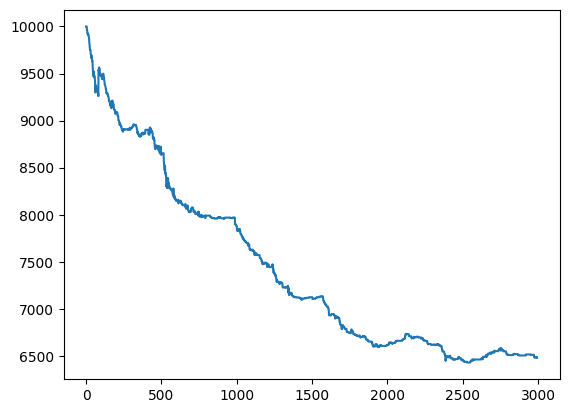

In [65]:
import matplotlib.pyplot as plt

plt.plot(long_history)

In [81]:
def trade_test(X_test, y_test, fitted_model, initial_budget = 10000, long=False, commision = 0.0004):
    history = []
    money = initial_budget


    for i in range(X_test.shape[0] - 1):
        y_pred = fitted_model.predict(X_test.iloc[i])
        close_in_ten_min = y_test.iloc[i + 1].item()
        open_now = y_test.iloc[i].item()
        history.append(money)

        if money >= open_now and y_pred == 1 and long == True:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money  // open_now)
            money += (close_in_ten_min - open_now) * (money  // open_now) - commission_now
            print(f"LONG! Earning {(close_in_ten_min - open_now) * (money  // open_now)} - commission {commission_now} -> budget: {money}")

        elif money >= open_now and y_pred == 0:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money // close_in_ten_min)
            money += (open_now - close_in_ten_min) * (money  // open_now) - commission_now

    print(f"\n\n\nMy budget before {initial_budget} and after trading {money}\nMommy, are you prod of me?")

    return money - initial_budget,  history
     

In [128]:
data = FinData("../../datasets/MTS_10_min.csv", indifference=1)
small_data = FinData("../../datasets/MTS_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 8, 1))
small_data.restrict_time_down(dt.datetime(2024, 8, 1))

num, cat = data.insert_all(mini_features=small_data.df)

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "class_weights" : [0.5, 1],
        "early_stopping_rounds" : 500}

test_date = dt.datetime(2024, 11, 15)
money = 10000
long_history = []
# while test_date <= dt.datetime(2024, 8, 10):
X_train, X_val, X_test, y_train, y_val, y_test, test_df = train_valid_test_split(data.df, test_date, 
                                                                                train_size=3000, val_size=500, test_size=500,
                                                                                numeric=num, cat=cat, target="direction_binary", 
                                                                                need_test=True)

test_date = test_df.iloc[-1]["utc"]
X_train_pca, X_val_pca, X_test_pca = mul_PCA(X_train, X_val, X_test)
model = CatboostFinModel(args)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)
model.set_features(num, cat)
model.fit(mod = False)


0:	learn: 0.6904922	test: 0.6913162	best: 0.6913162 (0)	total: 23.6ms	remaining: 1m 10s
1:	learn: 0.6878991	test: 0.6898095	best: 0.6898095 (1)	total: 52ms	remaining: 1m 18s
2:	learn: 0.6853750	test: 0.6881076	best: 0.6881076 (2)	total: 70.5ms	remaining: 1m 10s
3:	learn: 0.6828567	test: 0.6864050	best: 0.6864050 (3)	total: 96ms	remaining: 1m 11s
4:	learn: 0.6804405	test: 0.6847759	best: 0.6847759 (4)	total: 120ms	remaining: 1m 11s
5:	learn: 0.6781036	test: 0.6831159	best: 0.6831159 (5)	total: 143ms	remaining: 1m 11s
6:	learn: 0.6756928	test: 0.6815733	best: 0.6815733 (6)	total: 167ms	remaining: 1m 11s
7:	learn: 0.6733588	test: 0.6799582	best: 0.6799582 (7)	total: 188ms	remaining: 1m 10s
8:	learn: 0.6709828	test: 0.6781809	best: 0.6781809 (8)	total: 211ms	remaining: 1m 10s
9:	learn: 0.6687702	test: 0.6766100	best: 0.6766100 (9)	total: 235ms	remaining: 1m 10s
10:	learn: 0.6666002	test: 0.6750240	best: 0.6750240 (10)	total: 266ms	remaining: 1m 12s
11:	learn: 0.6643633	test: 0.6737455	best

In [129]:
print(model.score(X_val_pca, y_val))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       241
           1       0.52      1.00      0.69       259

    accuracy                           0.52       500
   macro avg       0.76      0.51      0.35       500
weighted avg       0.75      0.52      0.37       500



In [130]:
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.92      0.05      0.10       205
           1       0.60      1.00      0.75       295

    accuracy                           0.61       500
   macro avg       0.76      0.53      0.43       500
weighted avg       0.73      0.61      0.48       500



In [131]:
y_test = test_df["close"]
X_test_pca = pd.DataFrame(X_test_pca)
new_money, new_hist = trade_test(X_test_pca, y_test, fitted_model = model, initial_budget=money)
long_history += new_hist
money += new_money




My budget before 10000 and after trading 10134.381939999996
Mommy, are you prod of me?


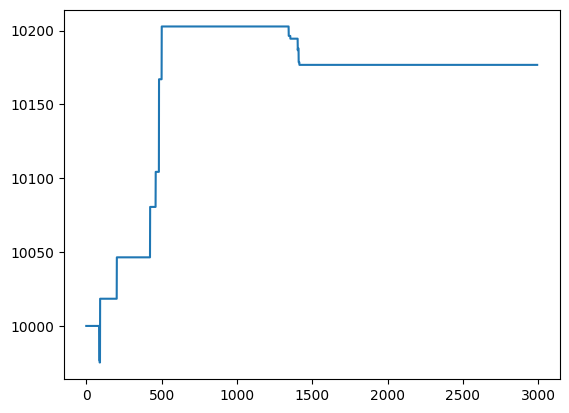

In [75]:
import matplotlib.pyplot as plt

plt.plot(long_history)